# Import dependencies

In [1]:

import numpy as np
import scipy
from typing import List
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation, buildControlFunctionAdjoint
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient,\
    integrateVectorFunction, getIdxMax, calculateFirstDual, calculateSecondDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep
from src.semiSmoothWalter import computeSSNStepWalter

# Set parameters

In [2]:
@dataclass
class Parameters:
    T = 1
    verbose = True
    useDummy = False
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 2e-9
    beta = 1e-7
    waveSpeed = 1
    randomFactor = 5
    maxIterations = 50
    pruneThreshold = 0
    maxNewtonSteps = 50
    newton_c = 5
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    solver = computeSSNStep
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

params = Parameters()

# Setup problem

In [3]:
def setupObservation(s1, s2, params):
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	control = buildControlFunction([g1, g2], [s1, s2], params)
	if not params.useDummy:
		K_u = solveStateEquation(control, params)
	else:
		K_u = control
	grid_size = K_u[0].x.array.shape
	raw_matrices = [K_u_t.x.array for K_u_t in K_u]
	norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
	scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
	np.random.seed(42)
	yd = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(yd)):
		yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
	params.yd = yd
	if not params.useDummy:
		params.yd_adjoint = solveAdjointEquation(params.yd, params)
	else:
		params.yd_adjoint = params.yd
	raw_data = np.array([func.x.array for func in params.yd])
	timePoints = np.linspace(0, params.T, num=len(params.yd))
	integrated_raw_data = scipy.integrate.cumulative_simpson(raw_data, x=timePoints, axis=0, initial=0)
	second_integrated_raw_data = scipy.integrate.cumulative_simpson(integrated_raw_data, x=timePoints, axis=0, initial=0)
	params.yd_dual = [fem.Function(params.V) for _ in params.yd]
	params.yd_second_dual = [fem.Function(params.V) for _ in params.yd]
	for idx, (func1, func2) in enumerate(zip(params.yd_dual, params.yd_second_dual)):
		func1.x.array[:] = integrated_raw_data[idx]
		func2.x.array[:] = second_integrated_raw_data[idx]
	#if not params.useDummy:
	#	params.yd_dual_adjoint = solveAdjointEquation(params.yd_dual, params)
	#	params.yd_second_dual_adjoint = solveAdjointEquation(params.yd_second_dual, params)
	#else:
	#	params.yd_dual_adjoint = params.yd_dual
	#	params.yd_second_dual_adjoint = params.yd_second_dual


# Minimization algorithm

In [4]:
def algorithm(active_set_init, weights_init, slope_init, y_shift_init, params: Parameters):
	active_set = []
	active_set[:] = active_set_init
	hesse = HesseMatrix(active_set, params)
 
	if params.verbose:
		print('Objective upper bound: ', computeObjective(np.concatenate((weights_init, slope_init, y_shift_init)), active_set_init, hesse.standard_states, params))
	weights = np.copy(weights_init)
	slope = np.copy(slope_init)
	y_shift = np.copy(y_shift_init)
	constraintViolation = np.empty(params.maxIterations)
	sizeActiveSet = np.empty(params.maxIterations)
	sizeActiveSet[:] = np.nan
	constraintViolation[:] = np.nan
	weights, slope, y_shift = params.solver(weights, slope, y_shift, active_set, hesse, params)
	if params.verbose:
		print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
	timePoints = np.linspace(0, params.T, num=len(params.yd))

	for k in range(params.maxIterations):
		discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse, params)
		if params.verbose:
			printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
			showNonStationarity(discreteDf, active_set, params)
		p_k = integrateVectorFunction(discreteDf, params)
		#p_k_old = calculateFirstDual(active_set, weights, slope, y_shift, hesse, params)
		#P_k = -integrateVectorFunction(p_k, params)
		#P_k_old = calculateSecondDual(active_set, weights, slope, y_shift, hesse, params)
		P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params) - p_k * timePoints[:, np.newaxis]
		if params.verbose:
			u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
			print('Boundary values of duals: ', p_k[-1,:]/params.alpha, P_k[-1,:]/params.beta)
			_, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
			plot_array(discreteDf, params.T, label='grad', ax=ax1)
			ax2.plot(timePoints, p_k/params.alpha, marker='o', linestyle='-', color='b', label='|p_k|/alpha')
			ax3.plot(timePoints, P_k/params.beta, marker='o', linestyle='-', color='b', label='|P_k|/beta')
			ax2.grid(True), ax3.grid(True)
			plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
			mpl.pyplot.show()

		idx_S = getIdxMax(p_k, active_set, type=0)
		idx_K = getIdxMax(P_k, active_set, type=1)
		norm_p_max = np.linalg.norm(p_k[idx_S])
		norm_P_max = np.linalg.norm(P_k[idx_K])
		if params.verbose:
			print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
		constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
		#print(constraintViolation[k])
		sizeActiveSet[k] = len(active_set)
		if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
			break
		if norm_p_max / params.alpha >= norm_P_max / params.beta:# or abs(idx_S * params.dt - params.T/2) > params.T/2 - params.beta/params.alpha:
			active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
		else:
			active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

		if params.verbose:
			print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)

		hesse.extendMatrix(active_set[-1])
		weights, slope, y_shift = params.solver(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		if params.verbose:
			print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
		hesse.pruneMatrix(active_set, weights)
		if params.verbose:
			print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))

	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
	fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
	plot_array(discreteDf, params.T, label='grad', ax=ax1)
	ax2.plot(timePoints, np.linalg.norm(p_k, axis=1)/params.alpha, marker='o', linestyle='-', color='b', label='|p_k|/alpha')
	ax3.plot(timePoints, np.linalg.norm(P_k, axis=1)/params.beta, marker='o', linestyle='-', color='b', label='|P_k|/beta')
	plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
	mpl.pyplot.show()
	printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
	showNonStationarity(discreteDf, active_set, params)
	return active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet


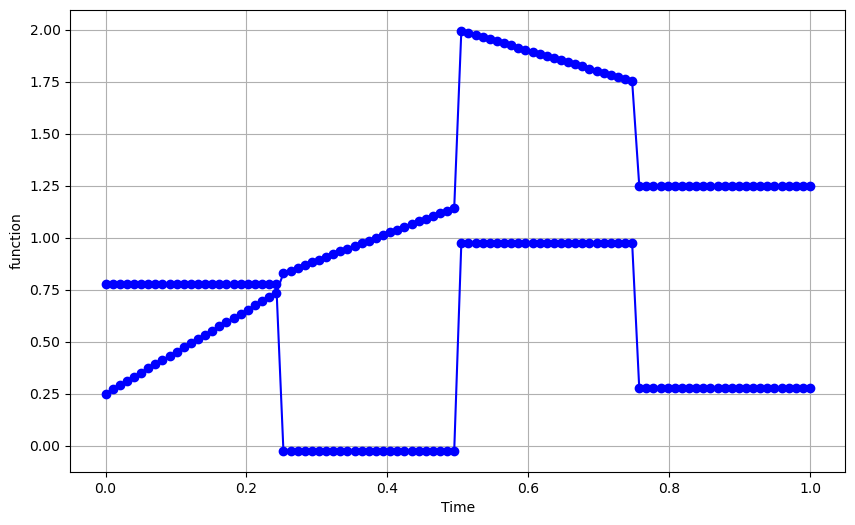

Test for alpha= 7e-09 , beta= 1e-09
Objective upper bound:  1.909280408965237e-06
weights:  [] slope:  [ 2.11739154 -0.13828923] y_shift [0.26623253 0.56485073]
Objective:  1.6599062743380034e-07
0 : Active set:
slope:  [ 2.11739154 -0.13828923] y_shift [0.26623253 0.56485073]
0 : Hesse condition: 59.68730315663469
First conditions:  [ 2.27828974e-09 -9.84421303e-10  2.84250218e-09  1.19880937e-09]  (should be close to 0)
Second conditions:  []  (should be greater or equal than 0)
Boundary values of duals:  [0.40607174 0.17125848] [-0.56421244 -2.18323067]


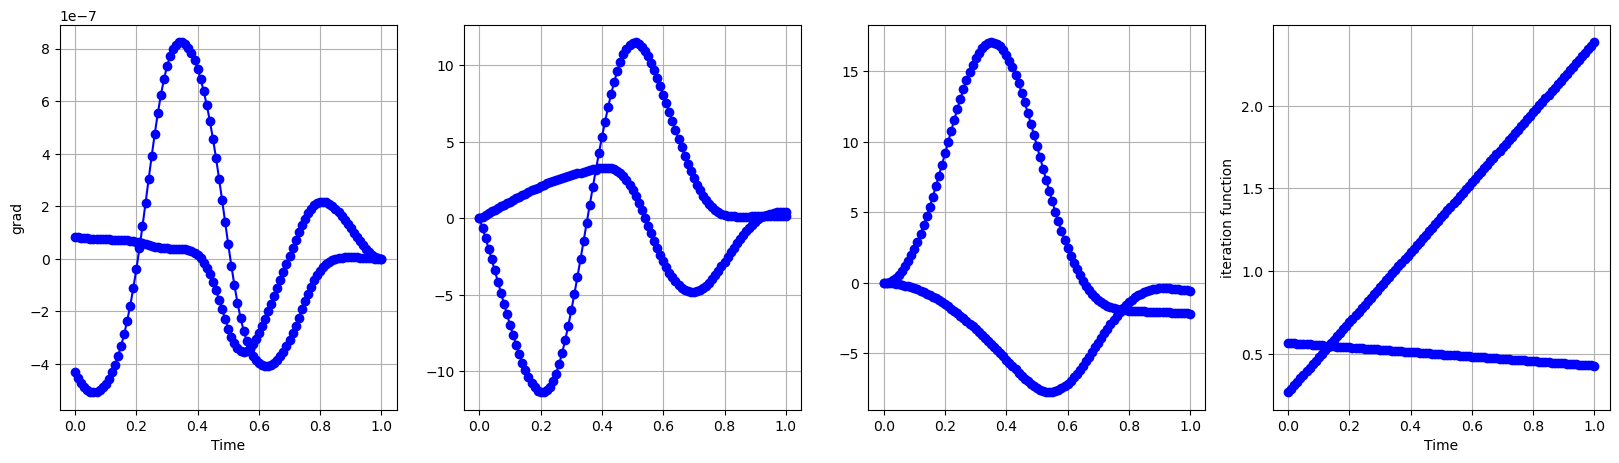

|p_max|/alpha:  11.637812342333714 , |P_max|/beta:  17.620703454577804
x_S:  0.5 x_K:  0.36 
New point: sigma= [-0.25694217  0.96642678] x_0 = 0.36 , type = 1
weights:  [4.2496835] slope:  [1.61924628 1.76662797] y_shift [ 0.54977518 -0.5161314 ]
Objective:  1.2871919301263386e-07
1 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 4.249683497676911 	id: 139956528986976
slope:  [1.61924628 1.76662797] y_shift [ 0.54977518 -0.5161314 ]
1 : Hesse condition: 1479.8530393435042
First conditions:  [1.73551696e-09 1.24022747e-09 2.87287826e-09 1.47696955e-09]  (should be close to 0)
Second conditions:  [1.]  (should be greater or equal than 0)
Boundary values of duals:  [0.41041118 0.21099565] [-1.1373613  -0.23674208]


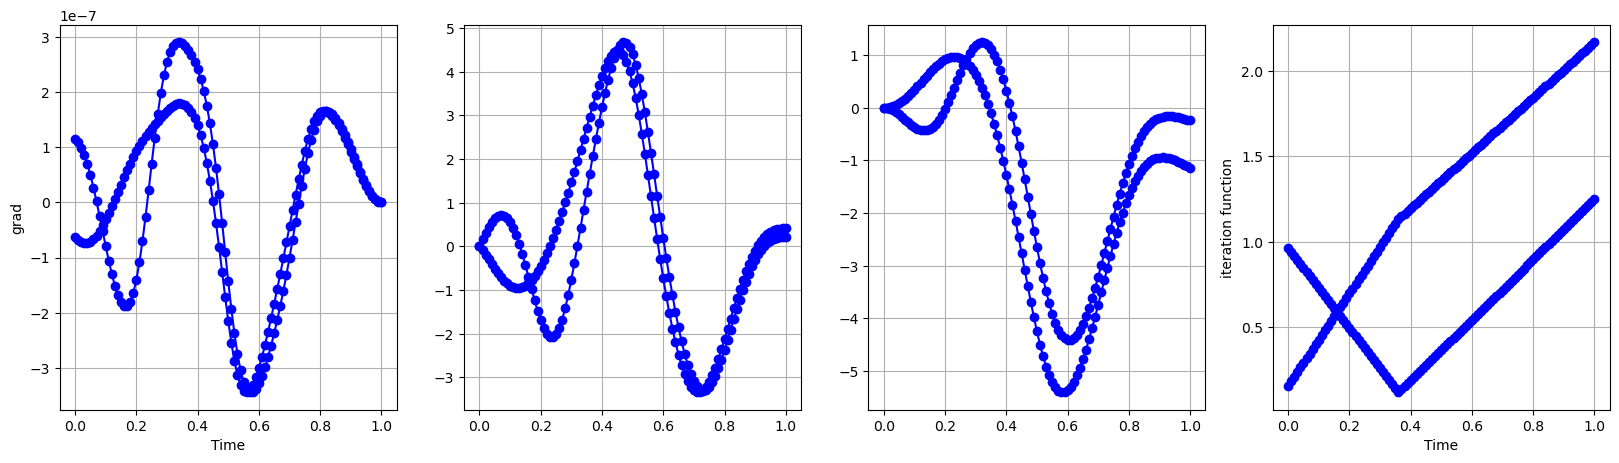

|p_max|/alpha:  6.418433802494933 , |P_max|/beta:  6.958533306869167
x_S:  0.46 x_K:  0.59 
New point: sigma= [-0.77669812 -0.62987302] x_0 = 0.59 , type = 1
weights:  [4.98820014 3.25963818] slope:  [1.93378606 2.42195033] y_shift [ 0.51167425 -0.77439473]
Objective:  1.1956453990020602e-07
2 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 4.988200135369801 	id: 139956528986976
	 1 sigma= [-0.77669812 -0.62987302] ,	x_0 = 0.59 ,	type = 1 	weight: 3.259638177397342 	id: 139956515814576
slope:  [1.93378606 2.42195033] y_shift [ 0.51167425 -0.77439473]
2 : Hesse condition: 3225.0484935633604
First conditions:  [2.86735706e-10 5.25458781e-10 1.75362524e-09 5.97351950e-10]  (should be close to 0)
Second conditions:  [1. 1.]  (should be greater or equal than 0)
Boundary values of duals:  [0.25051789 0.08533599] [-1.46688953 -0.07189317]


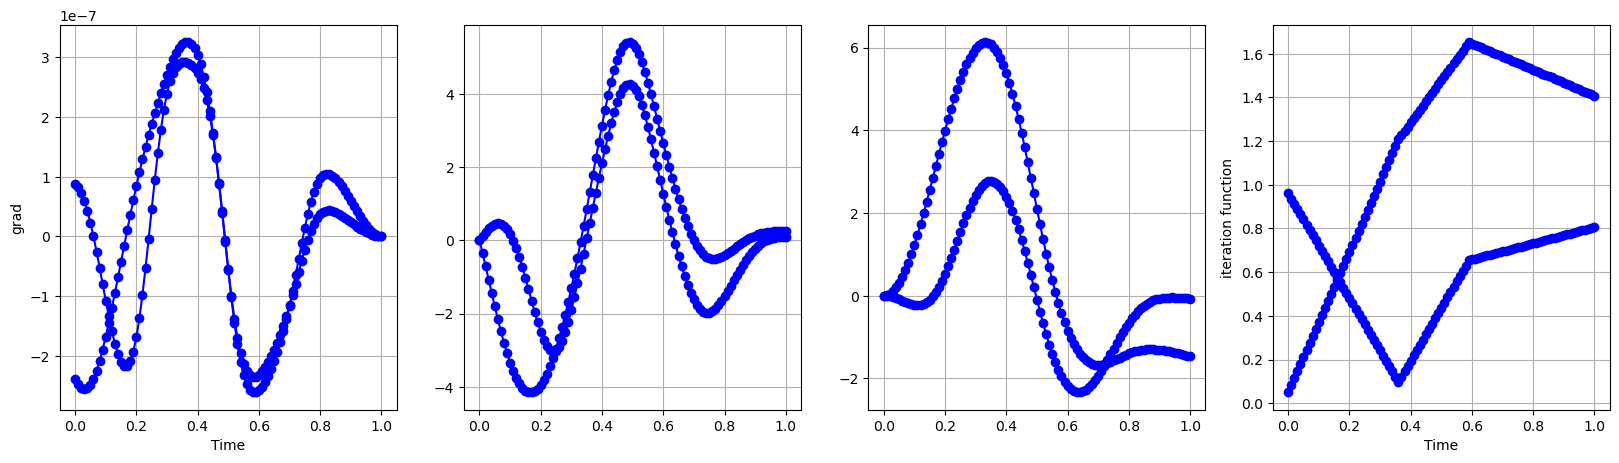

|p_max|/alpha:  6.878986491305362 , |P_max|/beta:  6.713537520062596
x_S:  0.49 x_K:  0.34 
New point: sigma= [0.78510792 0.61935899] x_0 = 0.49 , type = 0
weights:  [4.21166422 4.08312179 0.94610637] slope:  [0.92441773 1.20925339] y_shift [ 0.64816548 -0.42940715]
Objective:  8.762341085343311e-08
3 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 4.2116642200091645 	id: 139956528986976
	 1 sigma= [-0.77669812 -0.62987302] ,	x_0 = 0.59 ,	type = 1 	weight: 4.083121793163408 	id: 139956515814576
	 2 sigma= [0.78510792 0.61935899] ,	x_0 = 0.49 ,	type = 0 	weight: 0.9461063670354775 	id: 139956488128512
slope:  [0.92441773 1.20925339] y_shift [ 0.64816548 -0.42940715]
3 : Hesse condition: 3344.2039692803596
First conditions:  [ 2.62706853e-10  2.16897007e-11  3.80602935e-10 -5.26831189e-10]  (should be close to 0)
Second conditions:  [1.         1.         0.99999999]  (should be greater or equal than 0)
Boundary values of duals:  [ 0.05437185 -0.075261

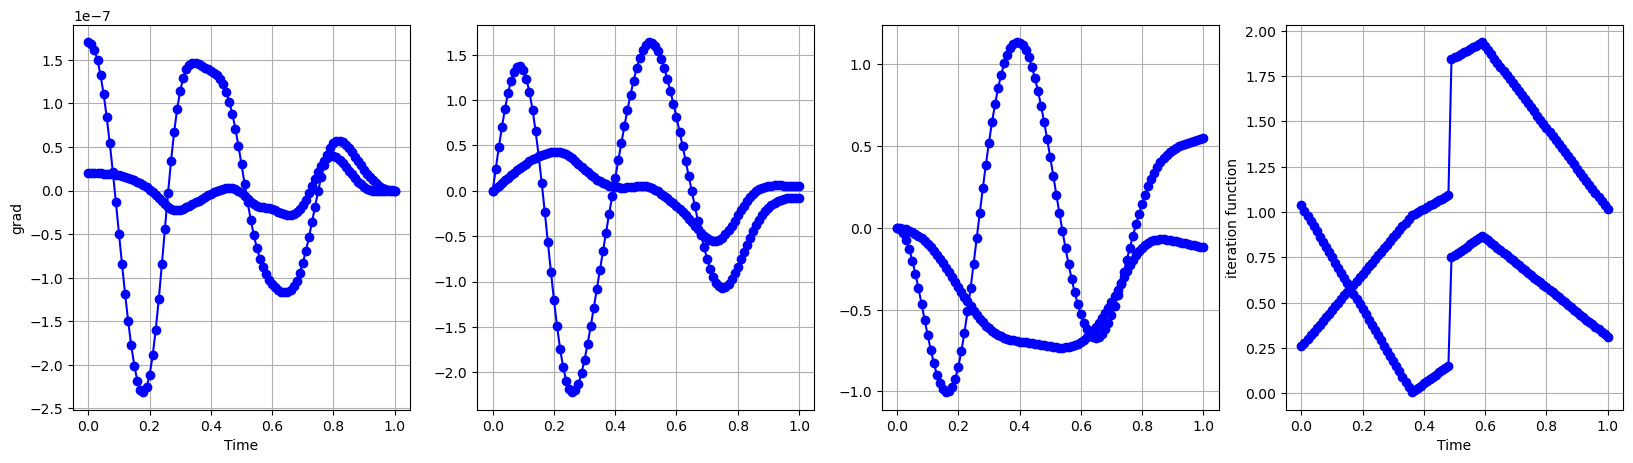

|p_max|/alpha:  2.2477901887336107 , |P_max|/beta:  1.3298178481819296
x_S:  0.26 x_K:  0.39 
New point: sigma= [ 0.15853866 -0.98735277] x_0 = 0.26 , type = 0
weights:  [2.55456553 4.36142443 0.91987971 0.51848469] slope:  [1.04022786 1.44750427] y_shift [ 0.52571851 -0.0350872 ]
Objective:  7.85996365633848e-08
4 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 2.554565529139932 	id: 139956528986976
	 1 sigma= [-0.77669812 -0.62987302] ,	x_0 = 0.59 ,	type = 1 	weight: 4.361424426199955 	id: 139956515814576
	 2 sigma= [0.78510792 0.61935899] ,	x_0 = 0.49 ,	type = 0 	weight: 0.919879713267117 	id: 139956488128512
	 3 sigma= [ 0.15853866 -0.98735277] ,	x_0 = 0.26 ,	type = 0 	weight: 0.5184846885005607 	id: 139956528469664
slope:  [1.04022786 1.44750427] y_shift [ 0.52571851 -0.0350872 ]
4 : Hesse condition: 6204.503340408878
First conditions:  [2.05915424e-10 6.13746568e-11 1.99350929e-10 1.75730142e-10]  (should be close to 0)
Second conditions:  [1. 

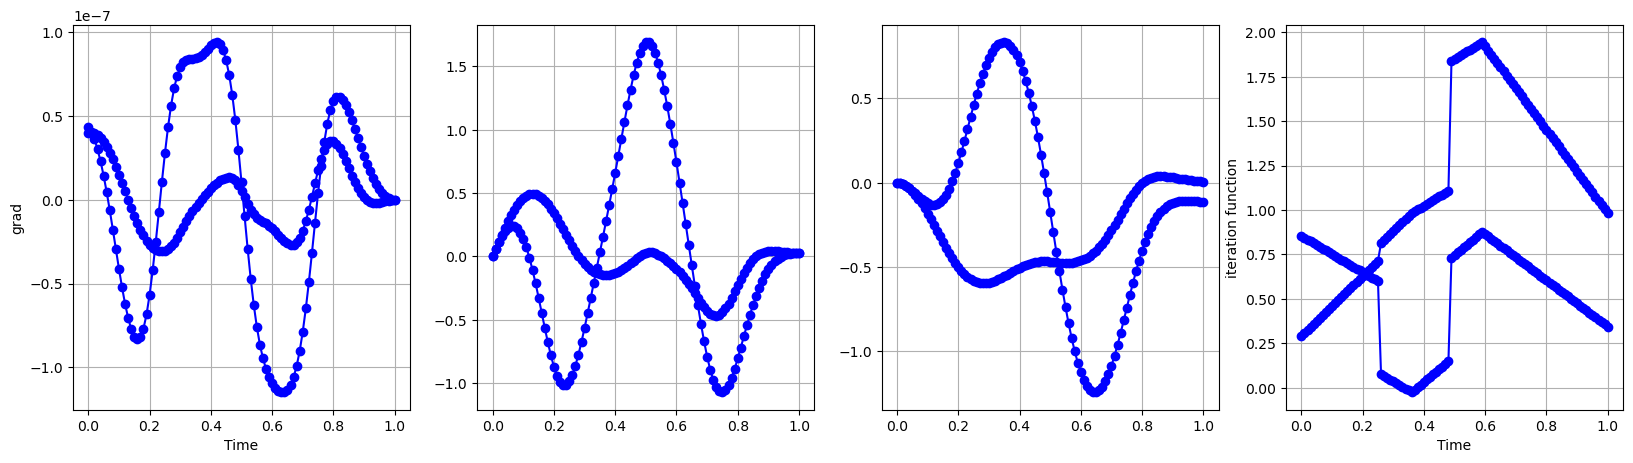

|p_max|/alpha:  1.688558164668995 , |P_max|/beta:  1.3097582296667456
x_S:  0.51 x_K:  0.64 
New point: sigma= [0.01920863 0.9998155 ] x_0 = 0.51 , type = 0
weights:  [1.59452407 4.15050701 0.73181727 0.50941559 0.41931214] slope:  [1.358288   0.52188329] y_shift [0.42657292 0.29883529]
Objective:  7.453901976736282e-08
5 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 1.5945240694096485 	id: 139956528986976
	 1 sigma= [-0.77669812 -0.62987302] ,	x_0 = 0.59 ,	type = 1 	weight: 4.1505070057802795 	id: 139956515814576
	 2 sigma= [0.78510792 0.61935899] ,	x_0 = 0.49 ,	type = 0 	weight: 0.7318172707533356 	id: 139956488128512
	 3 sigma= [ 0.15853866 -0.98735277] ,	x_0 = 0.26 ,	type = 0 	weight: 0.5094155916747558 	id: 139956528469664
	 4 sigma= [0.01920863 0.9998155 ] ,	x_0 = 0.51 ,	type = 0 	weight: 0.4193121382669027 	id: 139956533867296
slope:  [1.358288   0.52188329] y_shift [0.42657292 0.29883529]
5 : Hesse condition: 11886.648848194605
First condit

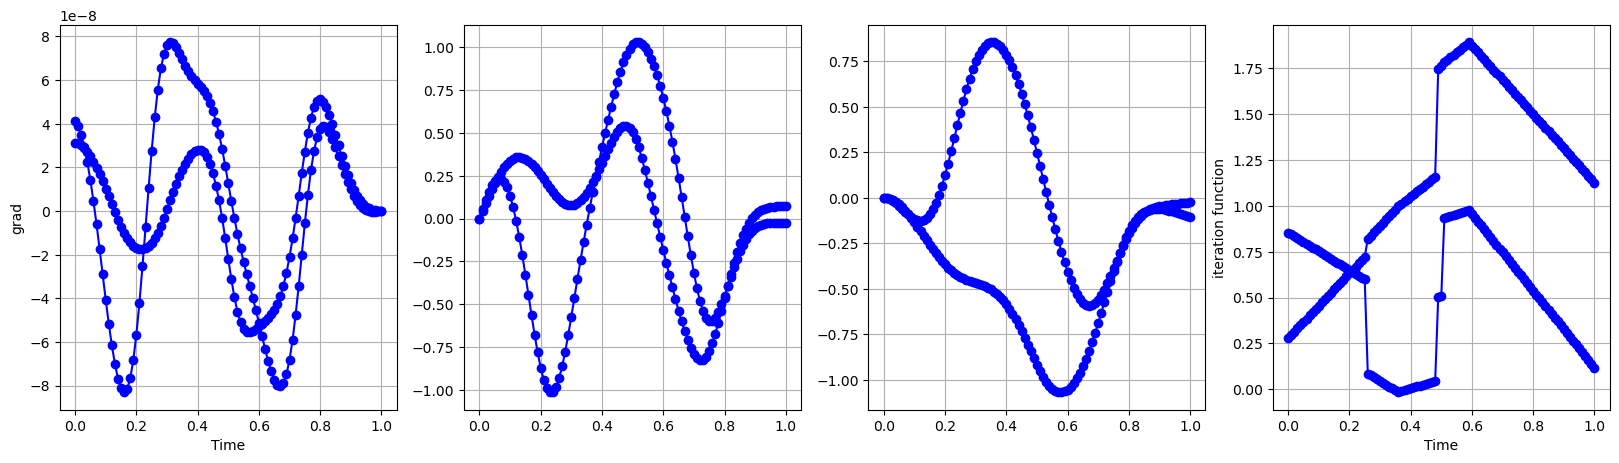

|p_max|/alpha:  1.1337456701790332 , |P_max|/beta:  1.133249977023368
x_S:  0.5 x_K:  0.61 
New point: sigma= [0.44399476 0.89602938] x_0 = 0.5 , type = 0
weights:  [1.45843277 4.19140852 0.20760588 0.51601309 0.         0.88247338] slope:  [1.43757288 0.3982124 ] y_shift [0.40768836 0.34614852]
Objective:  7.478124978854449e-08
6 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 1.4584327696262651 	id: 139956528986976
	 1 sigma= [-0.77669812 -0.62987302] ,	x_0 = 0.59 ,	type = 1 	weight: 4.191408519602396 	id: 139956515814576
	 2 sigma= [0.78510792 0.61935899] ,	x_0 = 0.49 ,	type = 0 	weight: 0.20760588305972422 	id: 139956488128512
	 3 sigma= [ 0.15853866 -0.98735277] ,	x_0 = 0.26 ,	type = 0 	weight: 0.5160130874228094 	id: 139956528469664
	 4 sigma= [0.44399476 0.89602938] ,	x_0 = 0.5 ,	type = 0 	weight: 0.8824733764912491 	id: 139956516767936
slope:  [1.43757288 0.3982124 ] y_shift [0.40768836 0.34614852]
6 : Hesse condition: 11890.173295707897
Firs

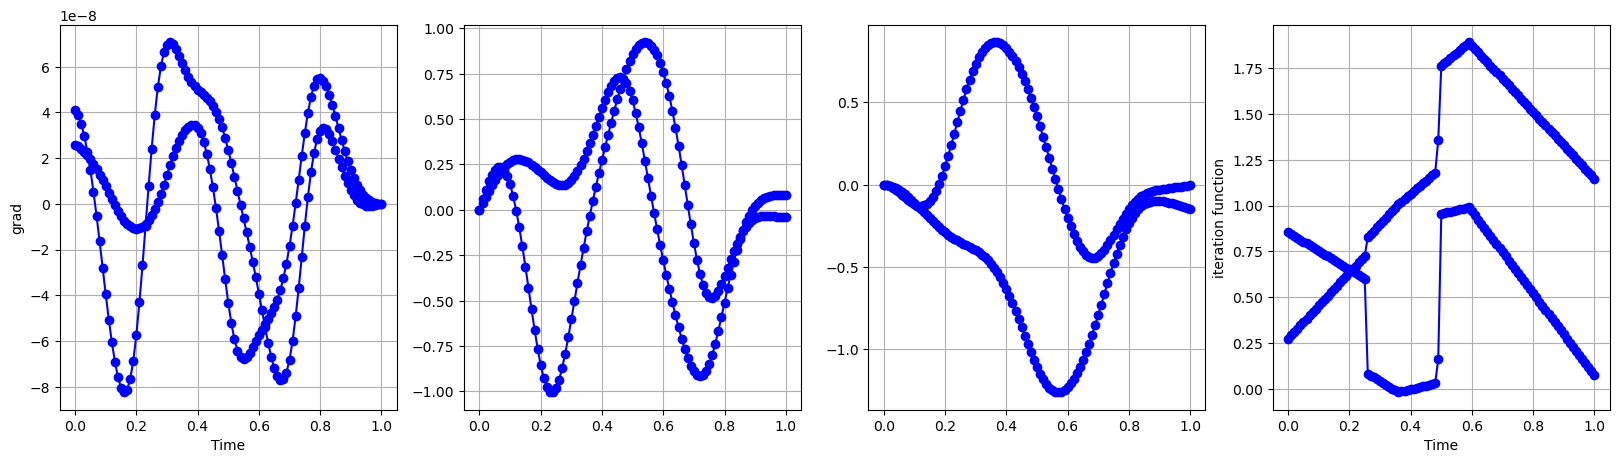

|p_max|/alpha:  1.0415160877599225 , |P_max|/beta:  1.2613611149067663
x_S:  0.48 x_K:  0.5700000000000001 
New point: sigma= [-0.99975153 -0.02229093] x_0 = 0.5700000000000001 , type = 1
weights:  [0.22848265 1.84085774 0.         0.46244243 1.26172861 2.26537598] slope:  [ 1.72314533 -0.80563854] y_shift [0.29891612 0.77043197]
Objective:  7.277758607332613e-08
7 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 0.2284826524115313 	id: 139956528986976
	 1 sigma= [-0.77669812 -0.62987302] ,	x_0 = 0.59 ,	type = 1 	weight: 1.8408577427309503 	id: 139956515814576
	 2 sigma= [ 0.15853866 -0.98735277] ,	x_0 = 0.26 ,	type = 0 	weight: 0.4624424343903731 	id: 139956528469664
	 3 sigma= [0.44399476 0.89602938] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2617286067772209 	id: 139956516767936
	 4 sigma= [-0.99975153 -0.02229093] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 2.2653759772683824 	id: 139956483142144
slope:  [ 1.72314533 -0.80563854] y_shift [0.29891612 0.7

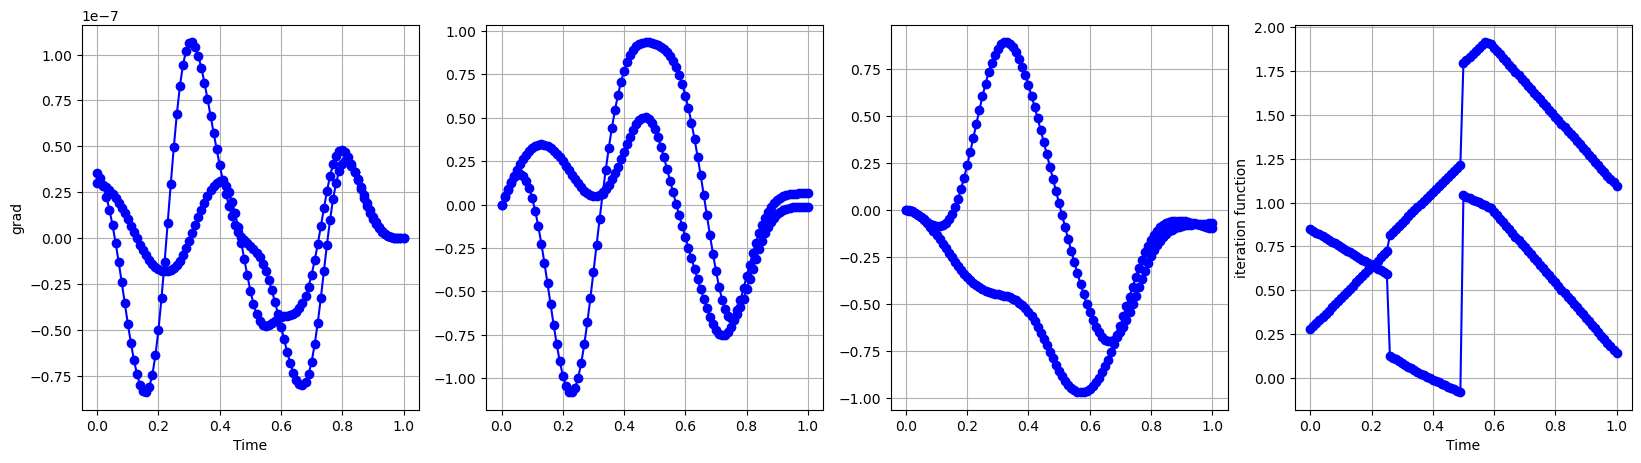

|p_max|/alpha:  1.0945609383545403 , |P_max|/beta:  1.1067386625856321
x_S:  0.22 x_K:  0.62 
New point: sigma= [-0.82726897 -0.56180606] x_0 = 0.62 , type = 1
weights:  [0.44399608 0.         0.47003043 1.19578248 1.59505497 2.81856444] slope:  [ 1.68491649 -0.58941321] y_shift [0.31630989 0.6951271 ]
Objective:  7.34664976961056e-08
8 : Active set:
	 0 sigma= [-0.25694217  0.96642678] ,	x_0 = 0.36 ,	type = 1 	weight: 0.44399608269641794 	id: 139956528986976
	 1 sigma= [ 0.15853866 -0.98735277] ,	x_0 = 0.26 ,	type = 0 	weight: 0.4700304344146549 	id: 139956528469664
	 2 sigma= [0.44399476 0.89602938] ,	x_0 = 0.5 ,	type = 0 	weight: 1.195782481303486 	id: 139956516767936
	 3 sigma= [-0.99975153 -0.02229093] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.5950549712402884 	id: 139956483142144
	 4 sigma= [-0.82726897 -0.56180606] ,	x_0 = 0.62 ,	type = 1 	weight: 2.818564440166383 	id: 139956481063296
slope:  [ 1.68491649 -0.58941321] y_shift [0.31630989 0.6951271 ]
8 : Hesse condition: 

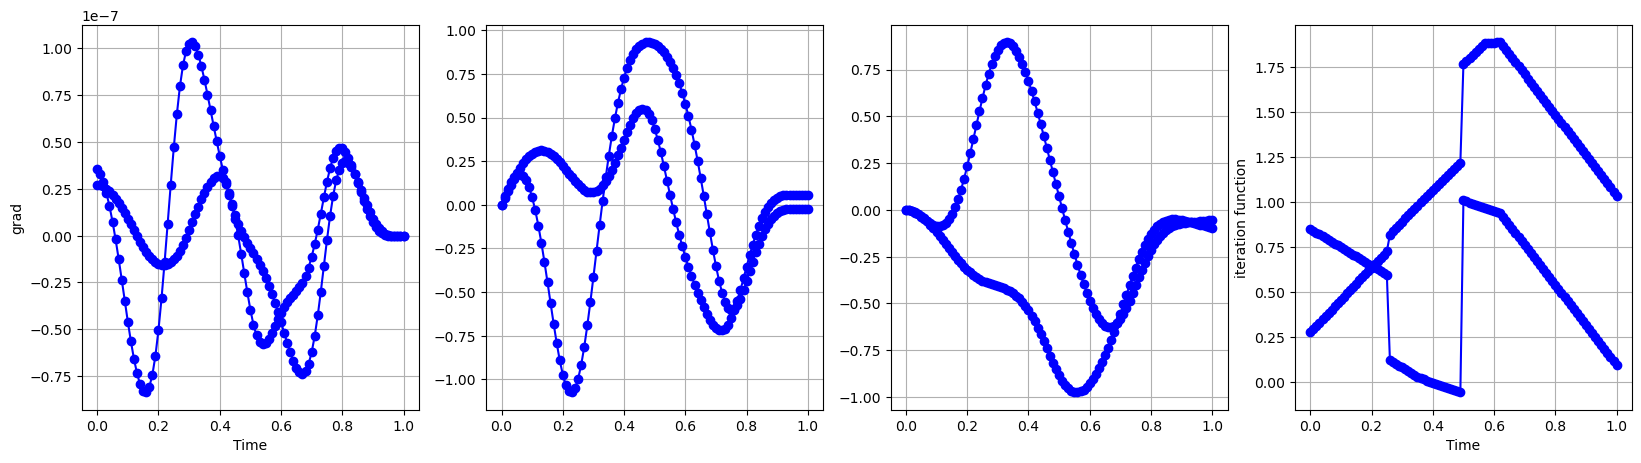

|p_max|/alpha:  1.0846570810631662 , |P_max|/beta:  1.0477494005679022


In [ ]:
def testRegularizationParameters(alpha, beta, params, originalSignal):
    params.alpha = alpha
    params.beta = beta
    print('Test for alpha=', alpha, ', beta=', beta)
    active_set = []
    weights = np.ones(len(active_set))
    slope = np.ones(params.d)
    y_shift = np.ones(params.d)    
    active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet = algorithm(active_set, weights, slope, y_shift, params)
    printIterationInfo(0, active_set, weights, slope, y_shift, np.identity(1))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    u_fin = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    reconstruction = np.array([u_fin(t) for t in timePoints])
    fig, (ax1, ax2) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(timePoints, originalSignal[:, 0], label='u(t)')
    ax1.plot(timePoints, reconstruction[:, 0], label='$\tilde{u}(t)$')
    ax2.plot(timePoints, originalSignal[:, 1], label='u(t)')
    ax2.plot(timePoints, reconstruction[:, 1], label='$\tilde{u}(t)$')
    mpl.pyplot.show()
    fig, (ax3, ax4) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    plot_array(constraintViolation, T=len(constraintViolation), label='Constraint violation', ax=ax3)
    ax3.set_yscale('log')
    plot_array(sizeActiveSet, T=len(sizeActiveSet), label='Size active set', ax=ax4)
    mpl.pyplot.show()

params.maxIterations = 15
params.newton_c = 1
params.maxNewtonSteps = 100
params.pruneThreshold = 0
params.verbose = True
params.mollify_const = 0.01
params.solver = computeSSNStepWalter

s1 = lambda t: (2*t+0.25 if t < 0.25 else(1.3*t + 0.5 if t < 0.5 else (-t+2.5 if t < 0.75 else 1.25)))
#s1 = lambda t : (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
#s1 = lambda t : (0.05*t if t <= 0.25 else (0.90*t + 1 if t <= 0.5 else -2 - 0.95*t if t <= 0.75 else 0.3)) #/ params.alpha
s2 = lambda t : (0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)))
setupObservation(s1, s2, params)

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
#gradient_test = buildControlFunctionAdjoint([g1, g2], solveAdjointEquation(params.yd, params), params)
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in timePoints])
array[:, 1] = np.array([s2(t) for t in timePoints])
plot_array(array, params.T)

testRegularizationParameters(7e-9, 1e-9, params, array)
#testRegularizationParameters(1e-8, 1e-6, params, array)
#testRegularizationParameters(5e-8, 1e-8, params, array)